## TSne T-distributed Stochastic Neighbor Embedding

Es una tecnica de reduccion de la dimensionalidad que utiliza los vecinos para expresar la similaridad entre ellos como una probailidad. El objetivo es preservar a estructura en una dimension menor. Ver [Paper](http://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf)

Definicion:
Tenemos los datos en el espacio original X, y los vamos a transfomar al espacio ${y}$ que esta en una menor dimension.

Este algoritmo es la evolucion de Stochastic Neighbor Embedding (SNE).
Que consiste en convertir la distancia entre 2 puntos en una probabilidad.
${\displaystyle p_{j\mid i}={\frac {\exp(-\lVert \mathbf {x} _{i}-\mathbf {x} _{j}\rVert ^{2}/2\sigma _{i}^{2})}{\sum _{k\neq i}\exp(-\lVert \mathbf {x} _{i}-\mathbf {x} _{k}\rVert ^{2}/2\sigma _{i}^{2})}},}$

 σi es la varianza de la Gaussiana centrada en el punto xi. Si hay puntos muy distantes deberia ser una varianza grande, si son puntos concentrados debe ser pequeña. Por lo que es necesario encontrar el valor de la varianza utilizando una busqueda binary, y el parametro perplexity, que es una medida relacionada con el numero de vecinos utilizados.
 
 $Perp(Pi) = 2^{H(Pi)}, H(Pi)=−\sum(p_{j|i} log2 ({p_{j|i})}).$
 


Para las ${y}$ tenemos.

${\displaystyle q_{j\mid i}=\frac{\exp(-\lVert \mathbf {y}_{i}-\mathbf {y} _{j}\rVert^{2} )}{\sum _{k\neq i}\exp(-\lVert \mathbf {y}_{i}-\mathbf {y}_{k}\rVert^{2} )},}$

con varianza ${\frac{1}{\sqrt{2}}}$

Si los elementos son iguales. Asignamos el valor de zero.

## Objetivo.
Minimizar las diferencia entre $p_{j\mid i} q_{ij}$, Para medir la distancia entre las 2 distribuciones se utiliza Kullback- Leibler divergence.


${\displaystyle Min(KL(P||Q))=\sum _{i\neq j}p_{j\mid i}\log {\frac {p_{j\mid i}}{q_{j\mid i}}}}$


Para minimzar utilizamos el gradiente descendiente.

$\frac{δ_C}{δ_{y_i}} =2\sum(p_{j\mid i}−q_{j\mid i}+p_{i\mid j}−q_{i\mid j})(y_i−y_j).$

### Simetric SNE

Utiliza una funcion simetrica. Que compara la join probability de P y Q.
${\displaystyle Min(KL(P||Q))=\sum _{ij}p_{ij}\log {\frac {p_{ij}}{q_{ij}}}}$

Para hacer el modelo mas robusto a los outliers, definimos la probabilidad pij en Simetric SNE, como: 
${\displaystyle p_{ij}={\frac {p_{j\mid i}+p_{i\mid j}}{2N}}}$

Y el gradiente es:
$\frac{δ_C}{δ_{y_i}} =4\sum(p_{ij}−q_{ij})(y_i−y_j).$

### T-SNE
Utiliza el modelo de la SImetric SNE, la principal diferencia es que hace los modelos
mas resistente en el espacio de baja dimensionalidad, se utilizara una t.

$q_{ij}={\frac {(1+\lVert \mathbf {y} _{i}-\mathbf {y} _{j}\rVert ^{2})^{-1}}{\sum _{k\neq l}(1+\lVert \mathbf {y} _{k}-\mathbf {y} _{l}\rVert ^{2})^{-1}}}$

$\frac{δ_C}{δ_{y_i}} =4\sum(p_{ij}−q_{ij})(y_i−y_j)(1+\lVert \mathbf {y} _{i}-\mathbf {y} _{j}\rVert ^{2})^{-1}.$

Figura tomada de http://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf

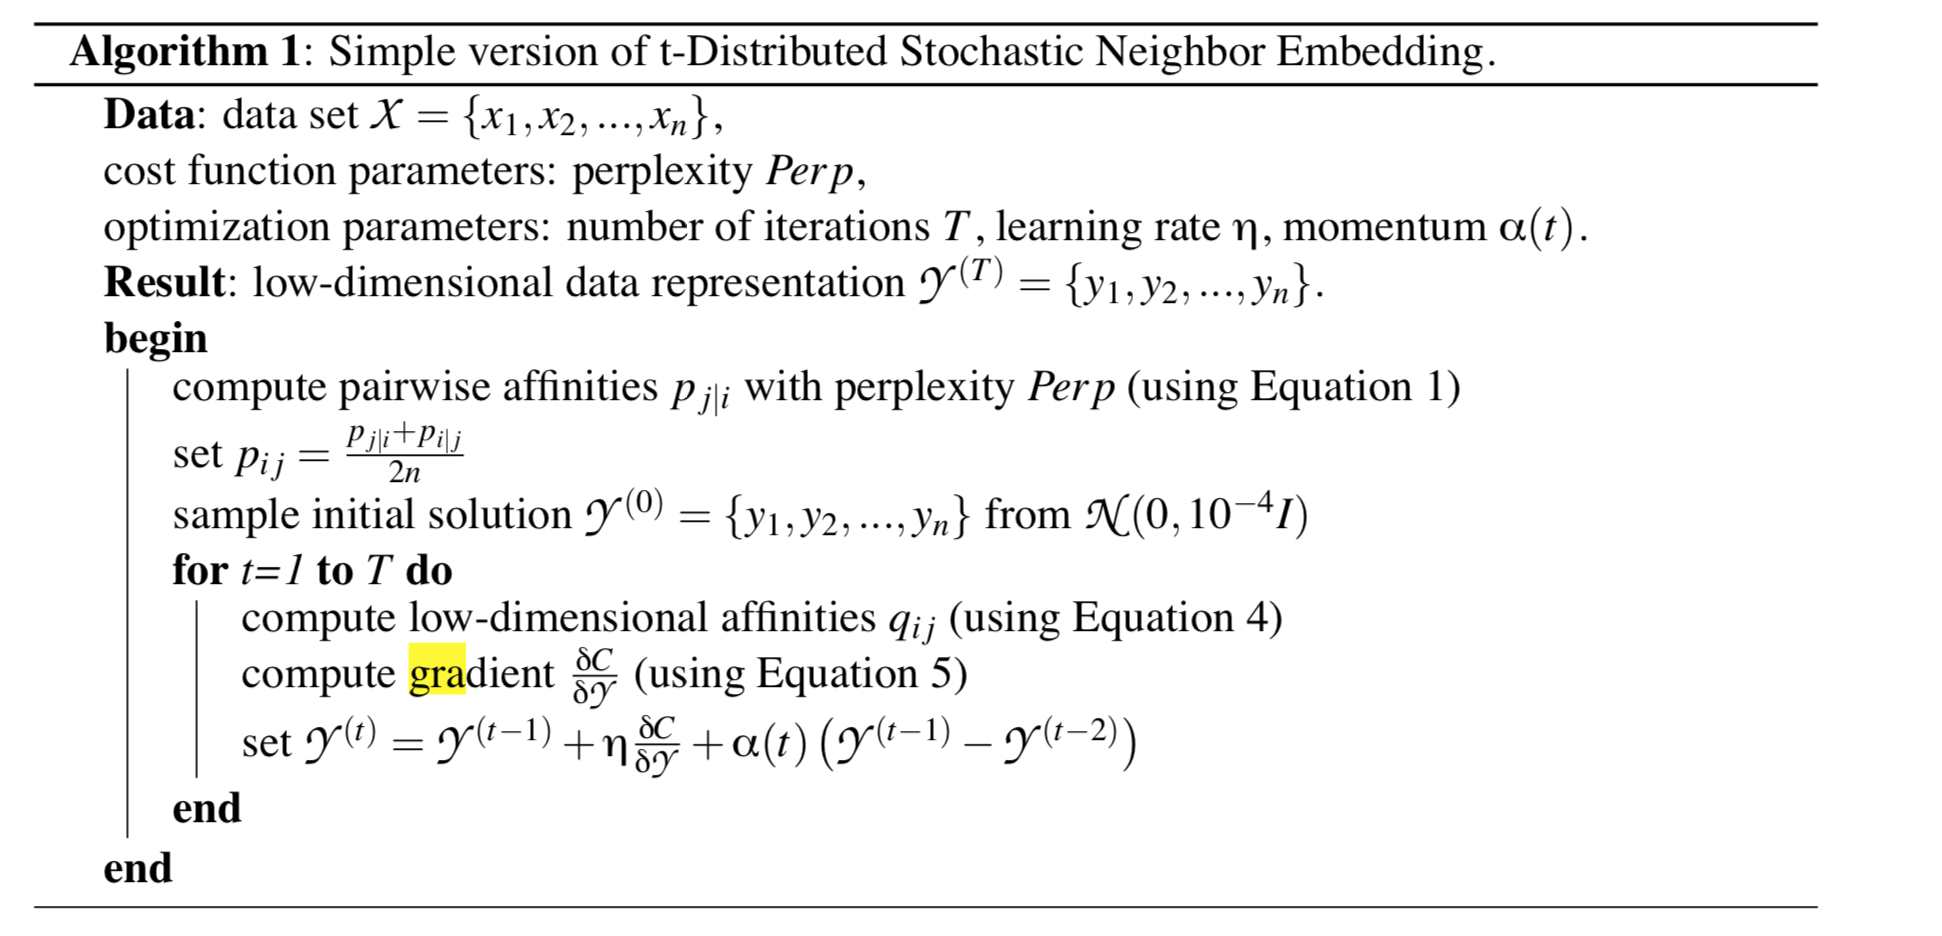


### Summary

En este modelo ya sabemos que el parametro perplexity esta relacionado con el numero de vecinos que se consideraran para seleccionar las posibles varianzas en el espacio inicial. Sin embargo, existen casos donde tenemos muchas distancias pequeñas. Para ser mejor diferenciados los cluster, se tiene otro parametro llamado early exaggeration, que consiste en multiplicar las distancias $P_i$ por un factor en las primeras interacciones del gradiente.

* T-sne tiende a conservar grandes distancias en P y pequeñas distancias en Q.
*

https://distill.pub/2016/misread-tsne/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os
import glob
import pickle
import numpy as np
import itertools
from urllib.request import urlretrieve
from os.path import isfile, isdir
from sklearn.decomposition import PCA
import tarfile

def download_files():
    """
    Este metodo descarga los archivos de imagenes sino existen
    """
    path_tar = os.path.join("data",'cifar-10-python.tar.gz')
    if not isfile(path_tar):
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            path_tar)
    dest_path =  "data"
    with tarfile.open(path_tar) as tar:
        tar.extractall(dest_path)
        tar.close()
download_files()

def get_data():
    """
    Este metodo lee los archivos descargados y crea una matriz con todos los ejemplos
    """
    folder = os.path.join("data",'cifar-10-batches-py')
    list_train = []
    test = None
    names_labels = None
    for n_file in glob.os.listdir(folder):
        if '_batch' in n_file:
            with open(os.path.join(folder,n_file),'rb') as temp_file:
                
                if 'test' in temp_file.name:
                    test = pickle.load(temp_file, encoding='latin1')
                else:
                    list_train.append(pickle.load(temp_file, encoding='latin1'))
        elif 'batches.meta' in n_file:
            with open(os.path.join(folder,n_file),'rb') as temp_file:
                names_labels = pickle.load(temp_file, encoding='latin1')["label_names"]
    X_test = test["data"]
    y_test = test["labels"]
    X_train = None
    y_train = None
    while len(list_train)>0:
        elem_dic = list_train.pop()
        if X_train is None:
            X_train = elem_dic["data"]
            y_train = elem_dic["labels"]
        else:
            X_train = np.concatenate((X_train, elem_dic["data"]),axis=0)
            y_train = np.concatenate((y_train, elem_dic["labels"]),axis=0)
    return X_train, y_train, X_test, y_test, names_labels  
fn_shape = lambda X: X.reshape(3, 32, 32).transpose(1, 2, 0)
X_train, y_train, X_test, y_test, names_labels = get_data()

In [ ]:
import numpy as np
from sklearn.manifold import TSNE

fn_shape = lambda X: X.reshape(3, 32, 32).transpose(1, 2, 0)

def rgb2gray(rgb, is_flat=True):
    rgb = fn_shape(rgb)
    img = np.dot(rgb[...,:3], [0.2125, 0.7154, 0.0721])
    if is_flat:
        img = img.flatten()
    return img   

def reduce_dim_tsne(components, X_train, X_test, perplexity=100, early_exaggeration=10 ):
    size_train = X_train.shape[0]
    X = np.vstack((X_train,X_test))
    X_tsne = TSNE(n_components=components,
                  verbose=0, 
                  early_exaggeration=early_exaggeration,
                  learning_rate=10,
                  perplexity=perplexity,
                  n_iter=1000
                 ).fit_transform( X )
    X_r = X_tsne[0:size_train,:]
    X_nr = X_tsne[size_train:,:]
    return X_r, X_nr

l = 4000
l_t = 30
s_X_train, s_y_train = np.apply_along_axis(rgb2gray,1,X_train[:l]), y_train[:l]
s_X_test, s_y_test = np.apply_along_axis(rgb2gray,1, X_test[:l_t]), y_test[:l_t]


c_scale = ['red', 'blue', 'black','green',
           'purple','yellow','violet',
           'brown','pink','gray']
dict_colors = [(ix,color) 
          for ix, color in enumerate(c_scale)]
lw = 1
fig = plt.figure(figsize=(40,40))
perplexity_list = [20,30, 50,100, 150, 300]
for f_i in range(len(perplexity_list)):
    
    ax = fig.add_subplot(3,3,f_i+1)
    # Clusterizamos en una dimension menor
    X_r, X_nr = reduce_dim_tsne(2, s_X_train, s_X_test, perplexity_list[f_i])
    for color, target_name in zip(dict_colors,names_labels ):
        ax.scatter(X_r[s_y_train == color[0], 0][:1000],
                   X_r[s_y_train == color[0], 1][:1000],
                    color=color[1][:1000], alpha=.4, lw=lw,
                    label=target_name)
    ax.legend(loc='best', shadow=False, scatterpoints=1)
    ax.set_title("T-sne con las categorias reales Per=%s"%perplexity_list[f_i])

plt.show()

In [ ]:
def plot_group(s_X_train,s_y_train, group = 5, f_num = 21, f_col = 4, is_gray=False):
    f_rows = int((0.5+f_num)/f_col)
    fig = plt.figure()
    for f_i in range(1,f_num):
        ax = fig.add_subplot(f_rows,f_col,f_i)
        if is_gray:
            ax.imshow(s_X_train[np.where(s_y_train==group)][f_i].reshape(32,32))
        else:
            ax.imshow(fn_shape(s_X_train[np.where(s_y_train==group)][f_i]))
            
plot_group(s_X_train,s_y_train, group = 7, f_num = 21, f_col = 4, is_gray=True)
plot_group(s_X_train,s_y_train, group = 8, f_num = 21, f_col = 4, is_gray=True)